# Spherical Gaussian experiment: generative results

## Setup

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging
import corner
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("../../")

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Load results

In [6]:
algo_filenames = [
    "flow",
    "pie",
    # "mf",
    "gamf",
    # "mf_specified",
    # "pie_specified"
]
algo_additionals = [
    "",
    "",
    # "",
    "", 
    # "",
    # "",
]
algo_labels = [
    "Flow",
    "PIE",
    # "Manifold flow",
    "GAMF",
    #"Specified MF",
    #"Specified PIE"
]
algo_colors = ["C{}".format(i) for i in range(10)]
algo_markers = ["o", "s", "^", "P", "x", "<"]

setup_filenames = [
    "2_3_0.010",
    #"2_3_0.001",
    #"2_3_0.100",
]
setup_labels = [
    r"2-sphere in 3 dim., $\epsilon = 0.01$",
    #r"2-sphere in 3 dim., $\epsilon = 0.001$",
    #r"2-sphere in 3 dim., $\epsilon = 0.1$",
]


In [7]:
def load(name, shape, numpyfy=True, result_dir="../data/results"):
    all_results = []
    
    for algo_filename in algo_filenames:
        results = []
        
        for setup_filename in setup_filenames:
            try:
                results.append(np.load(
                    "{}/{}_2_spherical_gaussian_{}_{}.npy".format(
                        result_dir, algo_filename, setup_filename, name
                    )
                ))
            except FileNotFoundError as e:
                print(e)
                
                if shape is None:
                    results.append(None)
                else:
                    results.append(np.nan*np.ones(shape))
            
        all_results.append(results)
    
    return np.asarray(all_results) if numpyfy else all_results

x_gen = load("samples", None, numpyfy=False)
logp_gen = load("samples_likelihood", (1000,))
distance_gen = load("samples_manifold_distance", (1000,))

true_test_log_likelihood = load("true_log_likelihood_test", (1000,))
model_test_log_likelihood = load("model_log_likelihood_test", (1000,))
model_test_reco_error = load("model_reco_error_test", (1000,))


In [10]:
min_logp = -100.
max_distance = 10.

mean_logp_gen = np.mean(np.clip(logp_gen, min_logp, None), axis=2)
mean_distance_gen = np.mean(np.clip(distance_gen, None, max_distance), axis=2)


## Plot generated samples

In [12]:
def show_corner(algo=None, show=0, boundary=1.5):
    if algo is None:
        print("Simulator")
        x = np.load("../data/samples/spherical_gaussian/spherical_gaussian_2_3_0.010_x_test.npy")
        _ = corner.corner(x, range=[(-boundary, boundary) for _ in range(3)], bins=10)
        
    else:
        print(algo_labels[algo])
        _ = corner.corner(x_gen[algo][show], range=[(-boundary, boundary) for _ in range(3)], bins=10)

In [38]:
def show_scatter(algo=None, show=0, boundary=1.5):
    if algo is None:
        print("Simulator")
        x = np.load("../data/samples/spherical_gaussian/spherical_gaussian_2_3_0.010_x_train.npy")[:1000]
    else:
        print(algo_labels[algo])
        x = x_gen[algo][show][:1000]
        
    fig = plt.figure(figsize=(5,5))
    ax = Axes3D(fig)
    ax.scatter(x[:,0], x[:,1], x[:,2])
    
    ax.set_xlim(-boundary, boundary)
    ax.set_ylim(-boundary, boundary)
    ax.set_zlim(-boundary, boundary)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_zlabel("$x_2$")
    
    plt.show()
    

Simulator


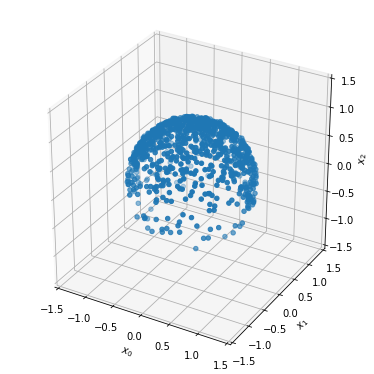

In [39]:
show_scatter()

Flow


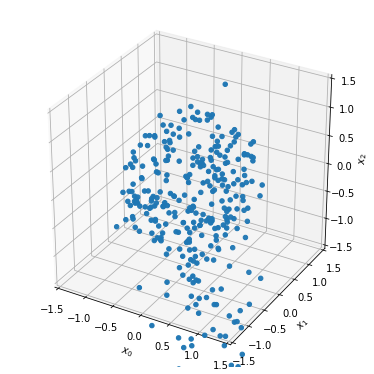

In [40]:
show_scatter(0)

PIE


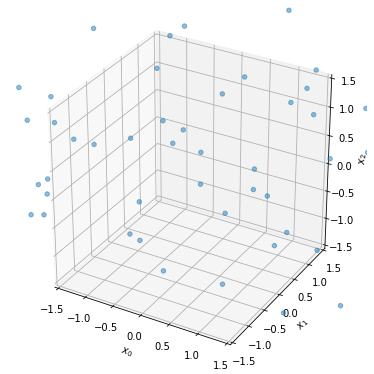

In [41]:
show_scatter(1)

GAMF


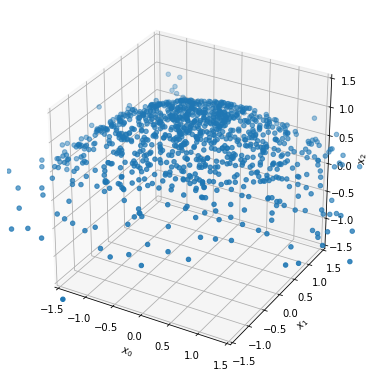

In [42]:
show_scatter(2)

## Evaluation metrics

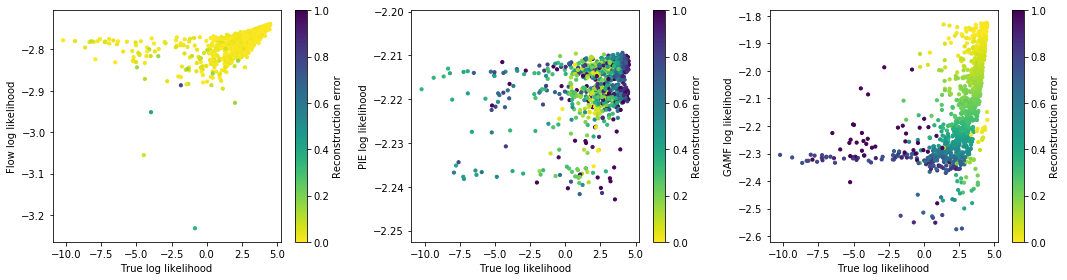

In [47]:
show = [0]

ncols = len(algo_labels)
nrows = len(show)

fig = plt.figure(figsize=(ncols*5, nrows*4))

for row, setting in enumerate(show):
    for col, algo_label in enumerate(algo_labels):
        ax = plt.subplot(nrows, ncols, setting*ncols + col + 1)
        
        sc = plt.scatter(
            true_test_log_likelihood[col, setting],
            model_test_log_likelihood[col, setting],
            c=model_test_reco_error[col, setting],
            s=10.,
            label=algo_label,
            cmap="viridis_r",
            vmin=0., vmax=1.
        )
        cbar = plt.colorbar(sc)
        
        plt.xlabel(r"True log likelihood")
        plt.ylabel(r"{} log likelihood".format(algo_label))
        cbar.set_label('Reconstruction error')
        
        # plt.xlim(-1.1,1.1)
        # plt.ylim(-1.1,1.1)
    
plt.tight_layout()
plt.savefig("../figures/test_likelihood_spherical_gaussian.pdf")


## Generative metrics

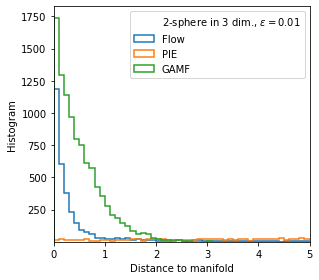

In [31]:
show = [0]
ncols = 3
nrows = (len(show) - 1) // ncols + 1

xmin, xmax = 0.,5.

fig = plt.figure(figsize=(ncols*4, nrows*4))

for panel, setting in enumerate(show):
    ax = plt.subplot(nrows, ncols, panel + 1)
    
    plt.plot([], [], lw=0., ls=" ", label=setup_labels[setting])
    
    for algo, (algo_label, c, m) in enumerate(zip(algo_labels, algo_colors, algo_markers)):
        plt.hist(
            distance_gen[algo, setting,:],
            range=(xmin, xmax), bins=50,
            label=algo_label,
            histtype="step",
            lw=1.5,
            color=c
        )
        
    plt.legend()

    plt.xlabel(r"Distance to manifold")
    plt.ylabel(r"Histogram")
    plt.xlim(xmin, xmax)
    plt.ylim(1.e-3, None)
    
plt.tight_layout()
plt.savefig("../figures/distance_distribution_spherical_gaussian.pdf")


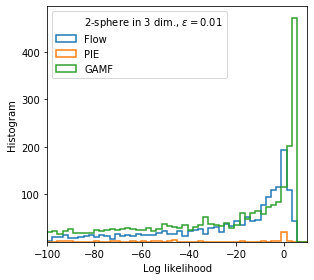

In [30]:
show = [0]
ncols = 3
nrows = (len(show) - 1) // ncols + 1

xmin, xmax = -100.,10.

fig = plt.figure(figsize=(ncols*4, nrows*4))

for panel, setting in enumerate(show):
    ax = plt.subplot(nrows, ncols, panel + 1)
    
    plt.plot([], [], lw=0., ls=" ", label=setup_labels[setting])
    
    for algo, (algo_label, c, m) in enumerate(zip(algo_labels, algo_colors, algo_markers)):
        plt.hist(
            logp_gen[algo, setting,:],
            range=(xmin, xmax), bins=50,
            label=algo_label,
            histtype="step",
            lw=1.5,
            color=c
        )
        
    plt.legend(loc="upper left")

    plt.xlabel(r"Log likelihood")
    plt.ylabel(r"Histogram")
    plt.xlim(xmin, xmax)
    plt.ylim(1.e-3, None)
    
plt.tight_layout()
plt.savefig("../figures/likelihood_distribution_spherical_gaussian.pdf")



09:07 matplotlib.legend              WARNING No handles with labels found to put in legend.


Flow [-87.94938959]
PIE [-99.68065189]
GAMF [-82.38644637]


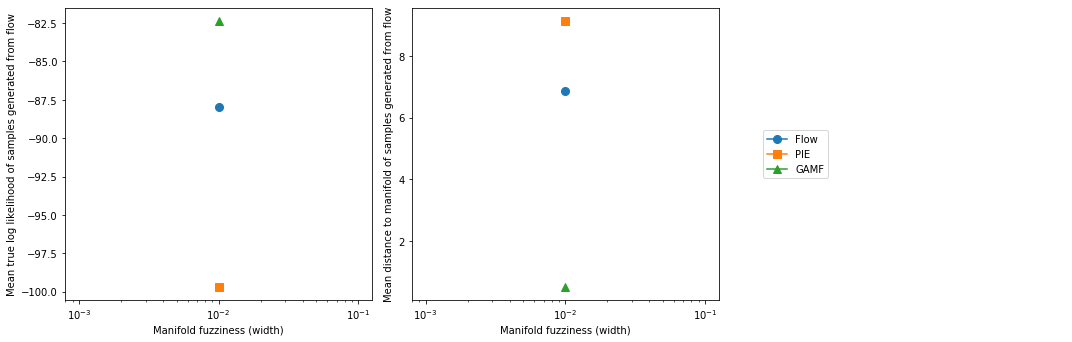

In [28]:
show = [0]
xs = [0.01, 0.1]

fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,3,1)
for mean_logp_gen_, algo_label, c, algo_marker in zip(mean_logp_gen, algo_labels, algo_colors, algo_markers):
    print(algo_label, mean_logp_gen_[show])
    plt.plot(xs, mean_logp_gen_[show], label=algo_label, ls="-", marker=algo_marker, ms=8., c=c)
# plt.legend()
plt.xscale("log")
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("Mean true log likelihood of samples generated from flow")

ax = plt.subplot(1,3,2)
for mean_distance_gen_, algo_label, c, algo_marker in zip(mean_distance_gen, algo_labels, algo_colors, algo_markers):
    plt.plot(xs, mean_distance_gen_[show], label=algo_label, ls="-", marker=algo_marker, ms=8, c=c)
#plt.legend()
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Manifold fuzziness (width)")
plt.ylabel("Mean distance to manifold of samples generated from flow")

ax = plt.subplot(1,3,3)
plt.legend()
for mean_logp_gen_, algo_label, c, algo_marker in zip(mean_logp_gen, algo_labels, algo_colors, algo_markers):
    plt.plot([], [], label=algo_label, ls="-", marker=algo_marker, ms=8., c=c)
plt.legend(loc="center left")
plt.axis("off")

plt.tight_layout()
plt.savefig("../figures/distance_likelihood_vs_epsilon_spherical_gaussian.pdf")
